In [14]:
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
from keras.utils import FeatureSpace
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split, KFold

import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style, init
from copy import deepcopy

In [15]:
class Config:
    target = 'Exercise angina'
    train = pd.read_csv('data/train.csv', index_col='id')
    test = pd.read_csv('data/test.csv', index_col='id')
    submission = pd.read_csv('data/sample_submission.csv')
    orig = pd.read_csv('data/Heart_Disease_Prediction.csv')
    train = pd.concat([orig[train.columns], train], axis=0, ignore_index=True)
    
    #device = 'cuda' if torch.cuda.is_available() else 'cpu'
    state = 42
    n_splits = 10
    early_stop = 100
    metric = 'roc_curve'
    task_type = "classification"
    task_is_classification = task_type == 'classification'
    if task_is_classification:
        n_classes = None
    else:
        n_classes = train[target].nunique()
        labels = list(train[target].unique())

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=state)

    outliers = False
    log_trf = False
    missing = False

In [18]:
class EDA(Config):
    
    def __init__(self):
        super().__init__()

        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        self.data_info()
        self.heatmap()
        self.dist_plots()
        self.cat_feature_plots()
        if self.task_is_classification:
            self.target_pie()
        else:
            self.target_plot()
                
    def data_info(self):
        
        for data, label in zip([self.train, self.test], ['Train', 'Test']):
            table_style = [{'selector': 'th:not(.index_name)',
                            'props': [('background-color', '#3cb371'),
                                      ('color', '#FFFFFF'),
                                      ('font-weight', 'bold'),
                                      ('border', '1px solid #DCDCDC'),
                                      ('text-align', 'center')]
                            }, 
                            {'selector': 'tbody td',
                             'props': [('border', '1px solid #DCDCDC'),
                                       ('font-weight', 'normal')]
                            }]
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} head\n')
            display(data.head().style.set_table_styles(table_style))
                           
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} info\n'+Style.RESET_ALL)               
            display(data.info())
                           
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} describe\n')
            display(data.describe().drop(index='count', columns=self.target, errors = 'ignore').T
                    .style.set_table_styles(table_style).format('{:.3f}'))
            
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} missing values\n'+Style.RESET_ALL)               
            display(data.isna().sum())
        return self
    
    def heatmap(self):
        print(Style.BRIGHT+Fore.GREEN+f'\nCorrelation Heatmap\n')
        plt.figure(figsize=(6, 6))
        corr = self.train[self.num_features+[self.target]].corr(method='pearson')
        sns.heatmap(corr, fmt = '0.2f', cmap = 'Greens', square=True, annot=True, linewidths=1, cbar=False)
        plt.show()
        
    def dist_plots(self):
        print(Style.BRIGHT+Fore.GREEN+f"\nDistribution analysis\n")
        df = pd.concat([self.train[self.num_features].assign(Source = 'Train'), 
                        self.test[self.num_features].assign(Source = 'Test'),], 
                        axis=0, ignore_index = True)

        fig, axes = plt.subplots(len(self.num_features), 2 ,figsize = (18, len(self.num_features) * 6), 
                                 gridspec_kw = {'hspace': 0.3, 
                                                'wspace': 0.2, 
                                                'width_ratios': [0.70, 0.30]
                                               }
                                )
        for i,col in enumerate(self.num_features):
            ax = axes[i,0]
            sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                        palette = ['#3cb371', 'r'], ax = ax, linewidth = 2
                       )
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col}")
            ax.grid()

            ax = axes[i,1]
            sns.boxplot(data = df, y = col, x=df.Source, width = 0.5,
                        linewidth = 1, fliersize= 1,
                        ax = ax, palette=['#3cb371', 'r']
                       )
            ax.set_title(f"\n{col}")
            ax.set(xlabel = '', ylabel = '')
            ax.tick_params(axis='both', which='major')
            ax.set_xticklabels(['Train', 'Test'])

        plt.tight_layout()
        plt.show()
               
    def cat_feature_plots(self):
        fig, axes = plt.subplots(max(len(self.cat_features), 1), 2 ,figsize = (18, len(self.cat_features) * 6), 
                                 gridspec_kw = {'hspace': 0.5, 
                                                'wspace': 0.2,
                                               }
                                )
        if len(self.cat_features) == 1:
            axes = np.array([axes])
            
        for i, col in enumerate(self.cat_features):
            ax = axes[i,0]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='#3cb371')
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Train")
            
            ax = axes[i,1]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='r')
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Test")

        plt.tight_layout()
        plt.show()

    def target_pie(self):
        print(Style.BRIGHT+Fore.GREEN+f"\nTarget feature distribution\n")
        targets = self.train[self.target]
        plt.figure(figsize=(6, 6))
        plt.pie(targets.value_counts(), labels=targets.value_counts().index, autopct='%1.2f%%', colors=sns.color_palette('viridis', len(targets.value_counts())))
        plt.show()

    def target_plot(self):
        print(Style.BRIGHT+Fore.GREEN+f"\nTarget feature distribution\n")
        
        fig, axes = plt.subplots(1, 2 ,figsize = (14, 6), 
                                 gridspec_kw = {'hspace': 0.3, 
                                                'wspace': 0.2, 
                                                'width_ratios': [0.70, 0.30]
                                               }
                                )
        ax = axes[0]
        sns.kdeplot(data = self.train[self.target], 
                    color = '#3cb371', ax = ax, linewidth = 2
                   )
        ax.set(xlabel = '', ylabel = '')
        ax.set_title(f"\n{self.target}")
        ax.grid()

        ax = axes[1]
        sns.boxplot(data = self.train, y = self.target, width = 0.5,
                    linewidth = 1, fliersize= 1,
                    ax = ax, color = '#3cb371'
                   )
        ax.set_title(f"\n{self.target}")
        ax.set(xlabel = '', ylabel = '')
        ax.tick_params(axis='both', which='major')

        plt.tight_layout()
        plt.show() 
        


Train head



,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.400000,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.600000,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.300000,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.200000,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.200000,1,1,3,Absence



Train info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630270 entries, 0 to 630269
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630270 non-null  int64  
 1   Sex                      630270 non-null  int64  
 2   Chest pain type          630270 non-null  int64  
 3   BP                       630270 non-null  int64  
 4   Cholesterol              630270 non-null  int64  
 5   FBS over 120             630270 non-null  int64  
 6   EKG results              630270 non-null  int64  
 7   Max HR                   630270 non-null  int64  
 8   Exercise angina          630270 non-null  int64  
 9   ST depression            630270 non-null  float64
 10  Slope of ST              630270 non-null  int64  
 11  Number of vessels fluro  630270 non-null  int64  
 12  Thallium                 630270 non-null  int64  
 13  Heart Disease            630270 non-null  obje

None


Train describe



,mean,std,min,25%,50%,75%,max
Age,54.137,8.257,29.000,48.000,54.000,60.000,77.000
Sex,0.715,0.452,0.000,0.000,1.000,1.000,1.000
Chest pain type,3.313,0.852,1.000,3.000,4.000,4.000,4.000
BP,130.498,14.977,94.000,120.000,130.000,140.000,200.000
Cholesterol,245.014,33.691,126.000,223.000,243.000,269.000,564.000
FBS over 120,0.080,0.271,0.000,0.000,0.000,0.000,1.000
EKG results,0.982,0.999,0.000,0.000,0.000,2.000,2.000
Max HR,152.815,19.115,71.000,142.000,157.000,166.000,202.000
ST depression,0.716,0.949,0.000,0.000,0.100,1.400,6.200
Slope of ST,1.456,0.545,1.000,1.000,1.000,2.000,3.000



Train missing values



Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64


Test head



,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
id,,,,,,,,,,,,,
630000,58,1,3,120,288,0,2,145,1,0.800000,2,3,3
630001,55,0,2,120,209,0,0,172,0,0.000000,1,0,3
630002,54,1,4,120,268,0,0,150,1,0.000000,2,3,7
630003,44,0,3,112,177,0,0,168,0,0.900000,1,0,3
630004,43,1,1,138,267,0,0,163,0,1.800000,2,0,7



Test info

<class 'pandas.core.frame.DataFrame'>
Index: 270000 entries, 630000 to 899999
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      270000 non-null  int64  
 1   Sex                      270000 non-null  int64  
 2   Chest pain type          270000 non-null  int64  
 3   BP                       270000 non-null  int64  
 4   Cholesterol              270000 non-null  int64  
 5   FBS over 120             270000 non-null  int64  
 6   EKG results              270000 non-null  int64  
 7   Max HR                   270000 non-null  int64  
 8   Exercise angina          270000 non-null  int64  
 9   ST depression            270000 non-null  float64
 10  Slope of ST              270000 non-null  int64  
 11  Number of vessels fluro  270000 non-null  int64  
 12  Thallium                 270000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 28.8 MB


None


Test describe



,mean,std,min,25%,50%,75%,max
Age,54.160,8.255,29.000,48.000,54.000,60.000,77.000
Sex,0.716,0.451,0.000,0.000,1.000,1.000,1.000
Chest pain type,3.315,0.852,1.000,3.000,4.000,4.000,4.000
BP,130.555,15.008,94.000,120.000,130.000,140.000,200.000
Cholesterol,245.045,33.695,126.000,223.000,243.000,269.000,564.000
FBS over 120,0.080,0.271,0.000,0.000,0.000,0.000,1.000
EKG results,0.978,0.999,0.000,0.000,0.000,2.000,2.000
Max HR,152.784,19.153,71.000,142.000,157.000,166.000,202.000
ST depression,0.718,0.947,0.000,0.000,0.100,1.400,6.200
Slope of ST,1.459,0.546,1.000,1.000,1.000,2.000,3.000



Test missing values



Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
dtype: int64


Correlation Heatmap



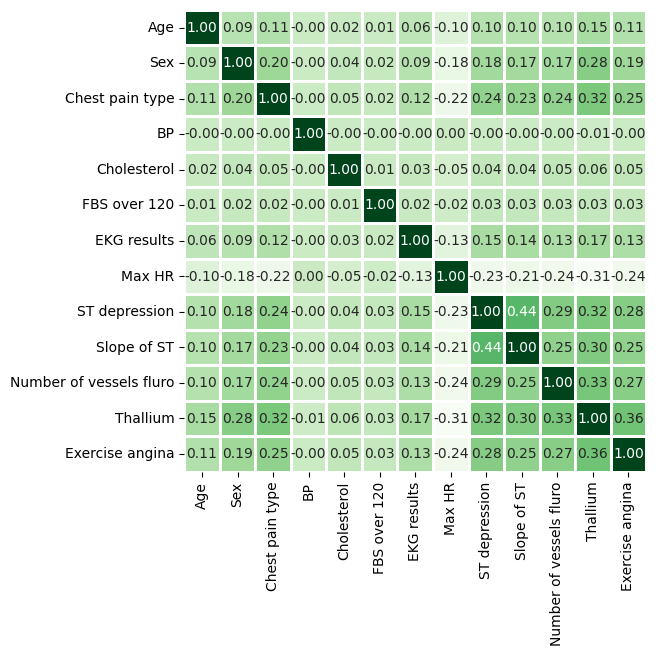


Distribution analysis



C:\Users\youne\AppData\Local\Temp\ipykernel_19152\620588559.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, y = col, x=df.Source, width = 0.5,
C:\Users\youne\AppData\Local\Temp\ipykernel_19152\620588559.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Train', 'Test'])
C:\Users\youne\AppData\Local\Temp\ipykernel_19152\620588559.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, y = col, x=df.Source, width = 0.5,
C:\Users\youne\AppData\Local\Temp\ipykernel_19152\620588559.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks

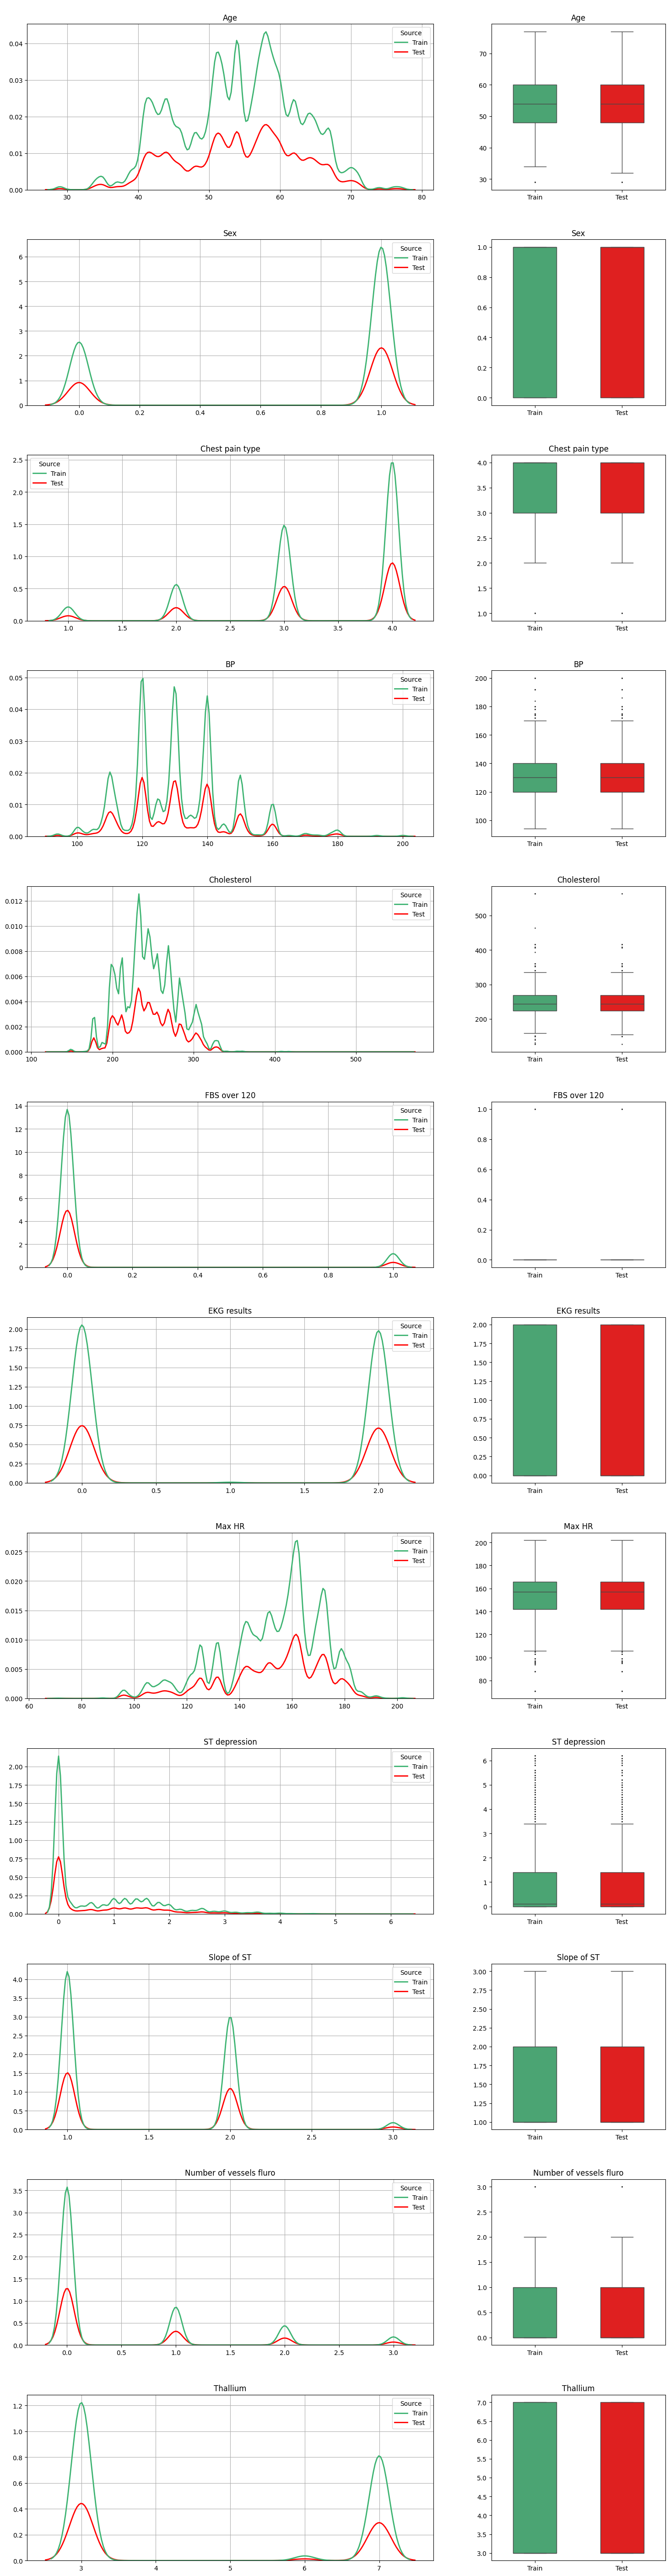

C:\Users\youne\AppData\Local\Temp\ipykernel_19152\620588559.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


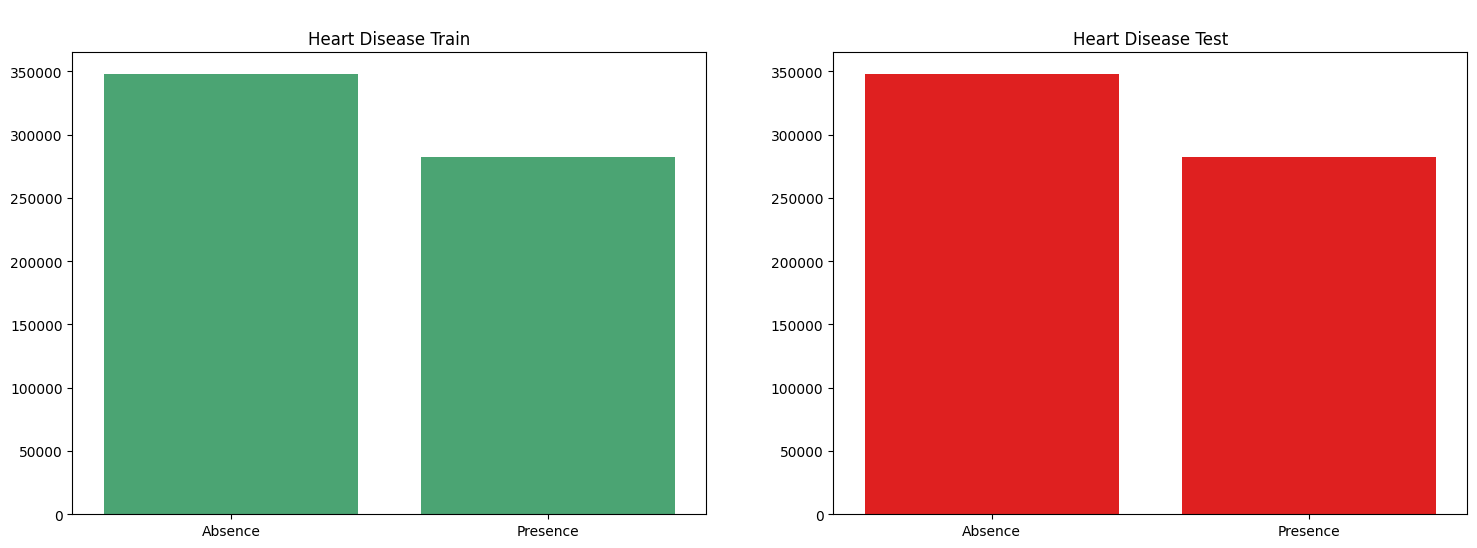


Target feature distribution



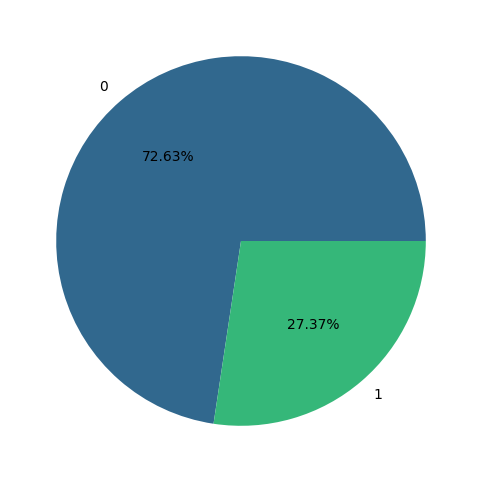

In [19]:
eda = EDA()
eda